In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Download the dataset
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
print("Path to dataset files:", path)

# Define dataset paths
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

100%|██████████| 1.98G/1.98G [00:18<00:00, 117MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


In [3]:
# Image preprocessing
image_size = (50, 50)  # Resize images to 50x50 for simplicity

train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=image_size, batch_size=32, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_path, target_size=image_size, batch_size=32, class_mode="categorical", shuffle=False
)

Found 3115 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


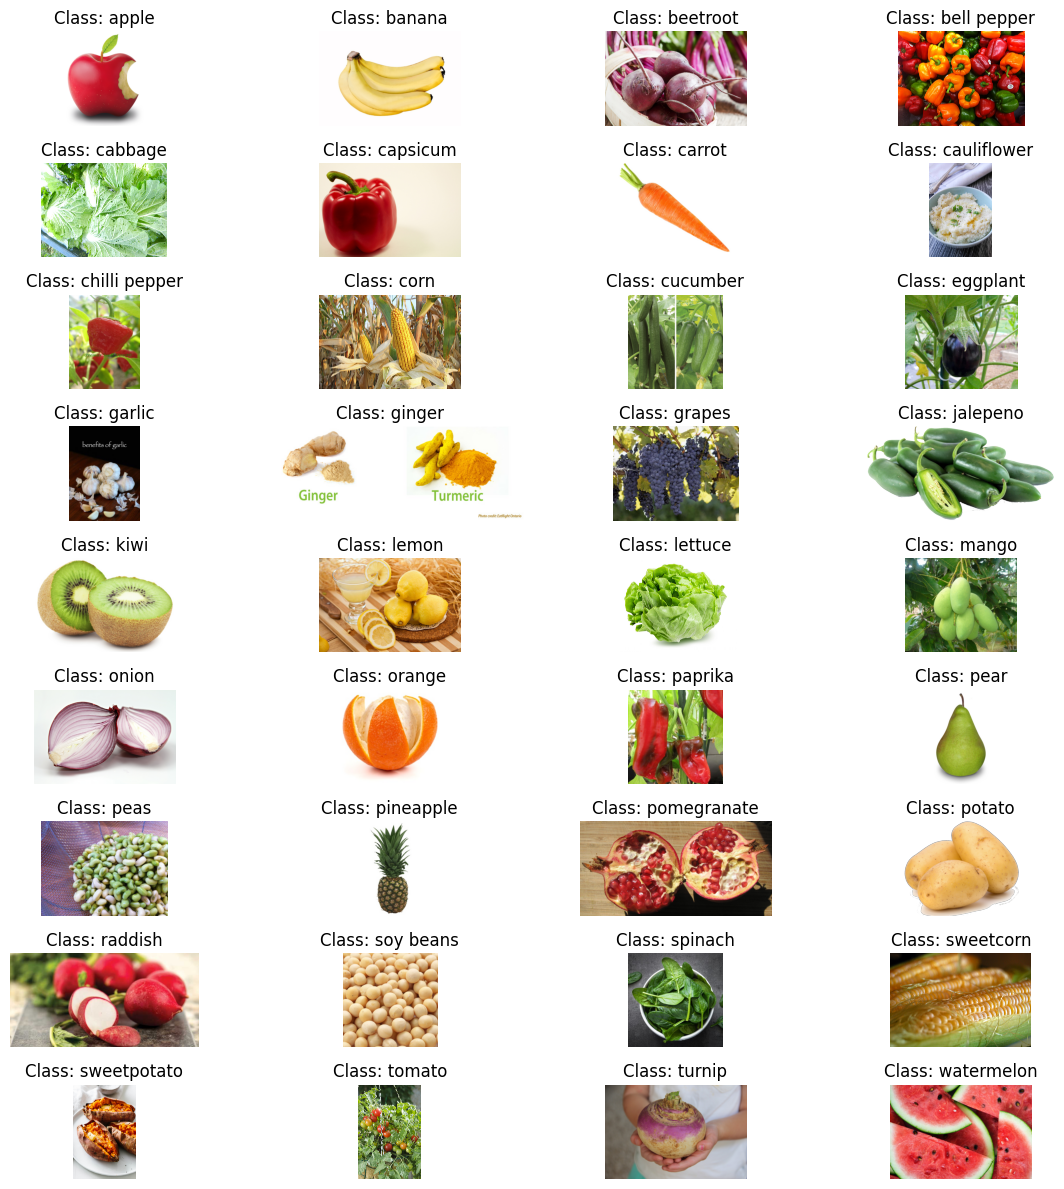

In [5]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

ncols = 4
nrows = (num_classes + ncols - 1) // ncols

# Show one image from each class
plt.figure(figsize=(12, 12))

for i, class_name in enumerate(class_labels):
    # Select one image from each class
    class_path = os.path.join(train_path, class_name)
    class_images = os.listdir(class_path)
    random_image_name = np.random.choice(class_images)
    image_path = os.path.join(class_path, random_image_name)

    # Load and plot the image
    image = plt.imread(image_path)
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Prepare data for ML models
def preprocess_for_ml(data_generator):
    data, labels = [], []
    for batch_data, batch_labels in data_generator:
        data.append(batch_data)
        labels.append(batch_labels)
        if len(data) >= len(data_generator):  # Get all data
            break
    data = np.vstack(data)
    labels = np.argmax(np.vstack(labels), axis=1)
    return data.reshape(data.shape[0], -1), labels

X_train, y_train = preprocess_for_ml(train_generator)
X_test, y_test = preprocess_for_ml(test_generator)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Logistic Regression

In [24]:
import numpy as np

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.epochs):
            # Compute linear model
            linear_model = np.dot(X, self.weights) + self.bias
            # Apply sigmoid function
            y_pred = 1 / (1 + np.exp(-linear_model))
            # Compute gradients
            dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
            db = (1 / self.m) * np.sum(y_pred - y)
            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = 1 / (1 + np.exp(-linear_model))
        return np.round(y_pred).astype(int)


from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


# Train Logistic Regression
logistic_model = LogisticRegressionScratch(learning_rate=0.01, epochs=100)
logistic_model.fit(X_train, y_train)
y_pred_lr = logistic_model.predict(X_test)

# Calculate accuracy
accuracy_lr = np.mean(y_pred_lr == y_test)
print("Logistic Regression Accuracy:", accuracy_lr)


Logistic Regression Accuracy: 0.9665738161559888


## Decision Tree

In [25]:
class DecisionTreeScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self.build_tree(X, y, depth=0)

    def build_tree(self, X, y, depth):
        if len(set(y)) == 1 or (self.max_depth and depth >= self.max_depth):
            return {"label": np.bincount(y).argmax()}
        feature, threshold = self.find_best_split(X, y)
        left_idx = X[:, feature] < threshold
        right_idx = ~left_idx
        return {
            "feature": feature,
            "threshold": threshold,
            "left": self.build_tree(X[left_idx], y[left_idx], depth + 1),
            "right": self.build_tree(X[right_idx], y[right_idx], depth + 1),
        }

    def find_best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self.information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain, best_feature, best_threshold = gain, feature, threshold
        return best_feature, best_threshold

    def information_gain(self, feature, y, threshold):
        left_idx = feature < threshold
        right_idx = ~left_idx
        if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
            return 0
        total_entropy = self.entropy(y)
        left_entropy = self.entropy(y[left_idx])
        right_entropy = self.entropy(y[right_idx])
        return total_entropy - len(y[left_idx]) / len(y) * left_entropy - len(y[right_idx]) / len(y) * right_entropy

    def entropy(self, y):
        p = np.bincount(y) / len(y)
        return -np.sum([pi * np.log2(pi) for pi in p if pi > 0])

    def predict(self, X):
        return np.array([self.traverse_tree(x, self.tree) for x in X])

    def traverse_tree(self, x, tree):
        if "label" in tree:
            return tree["label"]
        feature, threshold = tree["feature"], tree["threshold"]
        if x[feature] < threshold:
            return self.traverse_tree(x, tree["left"])
        else:
            return self.traverse_tree(x, tree["right"])

# Train Decision Tree
dt_model = DecisionTreeScratch(max_depth=10)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = np.mean(y_pred_dt == y_test)

print(f"Decision Tree Accuracy: {accuracy_dt}")

Decision Tree Accuracy: 0.9665738161559888


## Random Forest

In [26]:
import random

class RandomForestScratch:
    def __init__(self, n_trees=10, max_depth=None, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        for _ in range(self.n_trees):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = DecisionTreeScratch(max_depth=self.max_depth)
            # Use a random subset of features if max_features is specified
            if self.max_features:
                features = random.sample(range(X.shape[1]), self.max_features)
                X_sample = X_sample[:, features]
                tree.fit(X_sample, y_sample)
                self.trees.append((tree, features))
            else:
                tree.fit(X_sample, y_sample)
                self.trees.append((tree, None))

    def predict(self, X):
        predictions = []
        for tree, features in self.trees:
            if features:
                X_subset = X[:, features]
                predictions.append(tree.predict(X_subset))
            else:
                predictions.append(tree.predict(X))
        # Majority vote for classification
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=np.array(predictions))

# Train Random Forest
rf_model = RandomForestScratch(n_trees=10, max_depth=10, max_features=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = np.mean(y_pred_rf == y_test)

print(f"Random Forest Accuracy: {accuracy_rf}")


Random Forest Accuracy: 0.9610027855153204


## Support Vector Machine(SVM)

In [27]:
class SVMScratch:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_epochs=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_epochs = n_epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.where(y <= 0, -1, 1)  # Ensure binary labels are -1 and 1
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_epochs):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights - np.dot(x_i, y[idx]))
                    self.bias -= self.learning_rate * y[idx]

    def predict(self, X):
        linear_output = np.dot(X, self.weights) - self.bias
        return np.sign(linear_output).astype(int)

# Train SVM
# Convert to binary classification for this example
binary_y_train = (y_train == 0).astype(int)  # Only classify one class vs others
binary_y_test = (y_test == 0).astype(int)

svm_model = SVMScratch(learning_rate=0.001, lambda_param=0.01, n_epochs=1000)
svm_model.fit(X_train, binary_y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == binary_y_test)

print(f"SVM Accuracy: {accuracy_svm}")


SVM Accuracy: 0.83008356545961


In [28]:
# Test with a random image
random_idx = np.random.randint(len(X_test))
random_image = X_test[random_idx].reshape(1, -1)
true_label = y_test[random_idx]

pred_lr = lr_model.predict(random_image)[0]
pred_dt = dt_model.predict(random_image)[0]
pred_rf = rf_model.predict(random_image)[0]
pred_svm = svm_model.predict(random_image)[0]

print("\nRandom Test Image Prediction:")
print(f"True Label: {true_label}")
print(f"Logistic Regression Prediction: {pred_lr}")
print(f"Decision Tree Prediction: {pred_dt}")
print(f"Random Forest Prediction: {pred_rf}")
print(f"SVM Prediction: {pred_svm}")


Random Test Image Prediction:
True Label: 19
Logistic Regression Prediction: 19
Decision Tree Prediction: 19
Random Forest Prediction: 19
SVM Prediction: 19


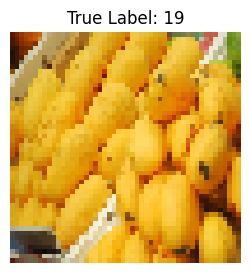

In [31]:
# Visualization of the random test image
plt.figure(figsize=(3, 3))
plt.imshow(X_test[random_idx].reshape(image_size[0], image_size[1], 3))  # Reshape image for visualization
plt.title(f"True Label: {true_label}")
plt.axis('off')
plt.show()

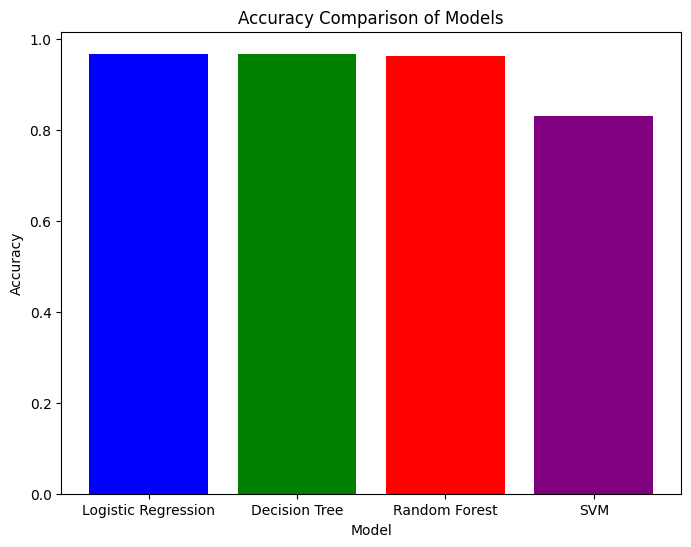

In [32]:
# Compare model accuracies and plot
accuracies = [acc_lr, acc_dt, acc_rf, acc_svm]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Models')
plt.show()

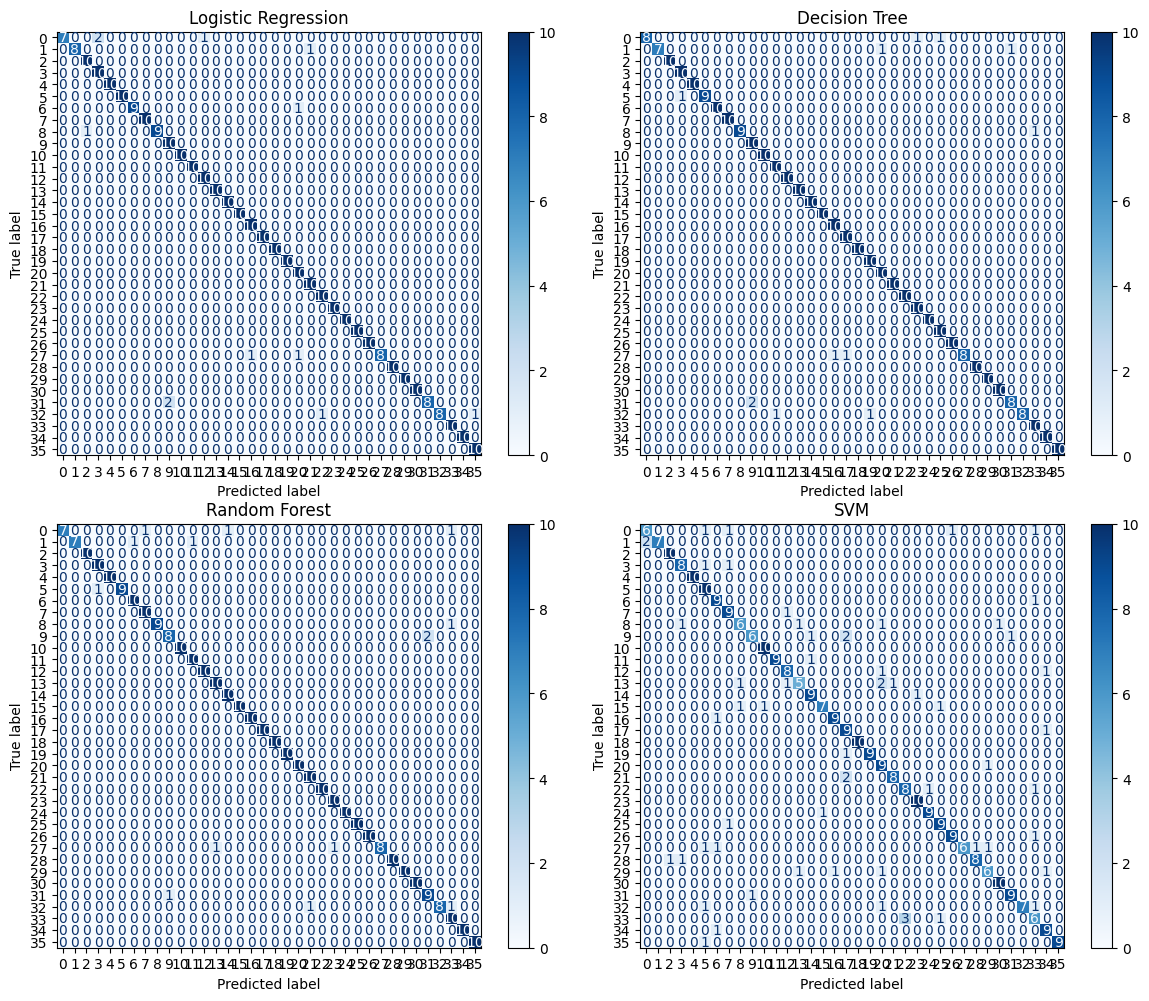

In [33]:
# Confusion Matrix for each model
models = [lr_model, dt_model, rf_model, svm_model]
predictions = [y_pred_lr, y_pred_dt, y_pred_rf, y_pred_svm]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.ravel()):
    cm = confusion_matrix(y_test, predictions[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(model_names[i])

plt.tight_layout()
plt.show()